In [1]:
# Importing ncessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = '/content/drive/MyDrive/Dataset'

Mounted at /content/drive


In [3]:
# Create ImageDataGenerator for data loading and augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [4]:
# Use flow_from_directory to load and split the data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',  # categorical classification
    subset='training',
    seed=42
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',  # categorical classification
    subset='validation',
    seed=42
)

Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.


In [5]:
# Load pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create the model by adding custom dense layers
x = layers.Flatten()(base_model.output)
predictions = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
# Train the model using the generators with the callback
class KeepSessionActiveAndSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("Colab is active! Epoch:", epoch + 1)
        # Save the model after each epoch
        self.model.save("/content/drive/MyDrive/ResNet50_30epoch.h5".format(epoch + 1))

model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[KeepSessionActiveAndSaveModel()]
)

Epoch 1/20
591/591 [==============================] - ETA: 0s - loss: 1.9511 - accuracy: 0.3175Colab is active! Epoch: 1


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


591/591 [==============================] - 5982s 10s/step - loss: 1.9511 - accuracy: 0.3175 - val_loss: 1.8326 - val_accuracy: 0.3378
Epoch 2/20
591/591 [==============================] - 429s 727ms/step - loss: 1.7120 - accuracy: 0.3913 - val_loss: 1.6476 - val_accuracy: 0.5095
Epoch 3/20
591/591 [==============================] - 430s 729ms/step - loss: 1.6213 - accuracy: 0.4224 - val_loss: 1.5961 - val_accuracy: 0.4919
Epoch 4/20
591/591 [==============================] - 401s 679ms/step - loss: 1.5611 - accuracy: 0.4410 - val_loss: 1.5316 - val_accuracy: 0.4374
Epoch 5/20
591/591 [==============================] - 423s 716ms/step - loss: 1.5203 - accuracy: 0.4477 - val_loss: 1.4892 - val_accuracy: 0.4352
Epoch 6/20
591/591 [==============================] - 425s 718ms/step - loss: 1.4839 - accuracy: 0.4678 - val_loss: 1.4725 - val_accuracy: 0.4464
Epoch 7/20
591/591 [==============================] - 437s 740ms/step - loss: 1.4514 - accuracy: 0.4796 - val_loss: 1.4492 - val_accurac

In [7]:
# Evaluate the model
# Load the pre-trained model from the .h5 file
model = load_model('/content/drive/MyDrive/ResNet50_30epoch.h5')

# Define the test dataset directory
test_data_dir = '/content/drive/MyDrive/Testing Dataset'

# Set up test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1000 images belonging to 10 classes.


32/32 [==============================] - 194s 6s/step


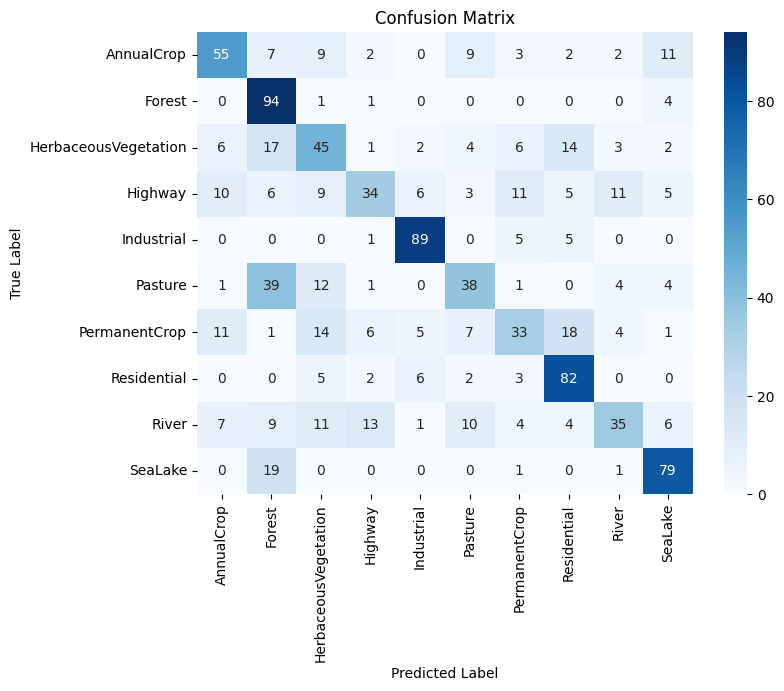

In [8]:
# Generate predictions for the test dataset
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix with numerical values
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [11]:
# Generate and print classification report
class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)
print("Classification Report:")
print(class_report)
accuracy = accuracy_score(true_labels, predicted_labels) * 100
print("The accuracy of ResNet50 Model is: ", accuracy)

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.61      0.55      0.58       100
              Forest       0.49      0.94      0.64       100
HerbaceousVegetation       0.42      0.45      0.44       100
             Highway       0.56      0.34      0.42       100
          Industrial       0.82      0.89      0.85       100
             Pasture       0.52      0.38      0.44       100
       PermanentCrop       0.49      0.33      0.40       100
         Residential       0.63      0.82      0.71       100
               River       0.58      0.35      0.44       100
             SeaLake       0.71      0.79      0.75       100

            accuracy                           0.58      1000
           macro avg       0.58      0.58      0.57      1000
        weighted avg       0.58      0.58      0.57      1000

The accuracy of ResNet50 Model is:  58.4


<ipython-input-12-914375cf5c0c>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='red', label='Random')


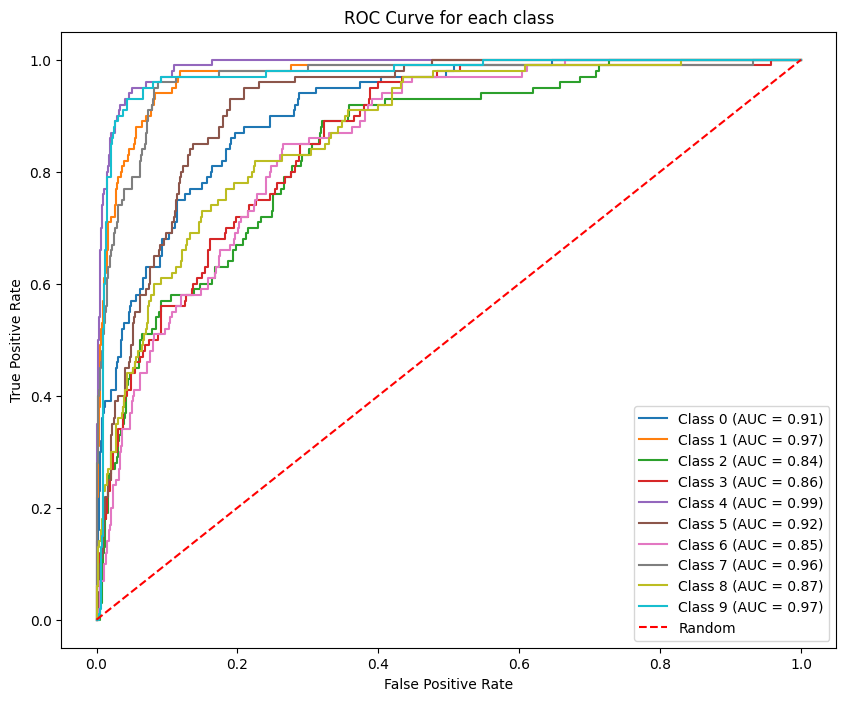

In [12]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(test_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(test_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', color='red', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc='best')
plt.show()

In [13]:
# Additional Metrics
# Define the number of classes
num_classes = len(test_generator.class_indices)

# Set a common threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary predictions
predicted_labels_binary = (predictions > threshold).astype(int)

# Extract True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
tp = int((accuracy / 100) * len(true_labels))
fp = len(true_labels) - tp
tn = int((accuracy / 100) * len(true_labels))
fn = len(true_labels) - tn

# Calculate True Positive Rate (TPR), False Positive Rate (FPR), Precision, Recall, F1 Score
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
precision = tp / (tp + fp)
recall = tpr
f1 = 2 * (precision * recall) / (precision + recall)

# Calculate Area Under ROC Curve (AUC)
roc_auc = dict()
for i in range(num_classes):
    fpr_i, tpr_i, _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr_i, tpr_i)

# Display the computed metrics for the dataset
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Area Under ROC Curve (AUC): {np.mean(list(roc_auc.values())):.4f}")

True Positive Rate (TPR): 0.5840
False Positive Rate (FPR): 0.4160
Precision: 0.5840
Recall: 0.5840
F1 Score: 0.5840
Area Under ROC Curve (AUC): 0.9161
